In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(), target_transform=None)

test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())



In [ ]:
image, label = train_data[0]
image, label

image.shape



In [ ]:
len(train_data.data), len(test_data.targets), len(test_data.data),len(test_data.targets)

In [ ]:
class_names = train_data.classes
class_names

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f'Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images')
print(f'Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images')


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
print(f"image size: {img.shape}")
print(f"label: {label}, label size: {label.shape}")

In [ ]:
from torch import nn


class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10,output_shape=len(class_names))
model_0.to('cpu')

In [ ]:
import requests
from pathlib import Path
if Path('helper_functions.py').is_file():
    print('helper_functions.py already downloaded')
else :
    print("downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(request.text)
        
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [ ]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float, device:torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
    

In [44]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n--------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(
        f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n"
    )

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device),
)

Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:09<00:04,  4.68s/it]


Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch 2
--------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:14<00:00,  4.68s/it]


Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 14.048 seconds


In [45]:
torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        pbar = tqdm(data_loader)
        for X, y in pbar:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        pbar.close()

        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc,
    }
    
model_0_results = eval_model(model=model_0, loss_fn=loss_fn, accuracy_fn=accuracy_fn, data_loader=test_dataloader)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 568.33it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_accuracy': 83.42651757188499}

In [46]:
## device agnostic-code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## NL Model
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )

    def forward(self, x: torch.tensor):
        return self.layer_stack(x)

In [47]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10,output_shape=len(class_names)).to(device)

In [48]:
## 6.1 setup loss optimizer evaluation metrics

from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong out model is
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) #tries to update our model's parameters to minimize the loss



In [49]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    train_loss, train_acc = 0, 0
    model.to(device)
    pbar = tqdm(data_loader)
    for (X, y) in pbar:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(
            y_true=y, y_pred=y_pred.argmax(dim=1)
        )  # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    pbar.close()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        pbar = tqdm(data_loader, total=len(data_loader))
        for X, y in pbar:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),  # Go from logits -> pred labels
            )
        pbar.close()

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [50]:
torch.manual_seed(42)

from timeit import default_timer as timer

train_time_start_on_gpu = timer()
epochs = 3
pbar = tqdm(range(epochs), desc="Epochs")

for epoch in pbar:
    print(f"Epoch {epoch+1} of {epochs}")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        accuracy_fn=accuracy_fn,
    )
    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        device=device,
        accuracy_fn=accuracy_fn,
    )

pbar.close()

train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(
    start=train_time_start_on_gpu, end=train_time_end_on_gpu
)

Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 of 3


100%|██████████| 1875/1875 [00:05<00:00, 344.03it/s]


Train loss: 0.83069 | Train accuracy: 70.69%


Epochs:  33%|███▎      | 1/3 [00:06<00:12,  6.06s/it]

Test loss: 0.59298 | Test accuracy: 79.19%

Epoch 2 of 3


100%|██████████| 1875/1875 [00:05<00:00, 341.80it/s]


Train loss: 0.48518 | Train accuracy: 82.80%


Epochs:  67%|██████▋   | 2/3 [00:12<00:06,  6.07s/it]

Test loss: 0.49782 | Test accuracy: 82.71%

Epoch 3 of 3


100%|██████████| 1875/1875 [00:05<00:00, 346.13it/s]


Train loss: 0.45107 | Train accuracy: 84.04%


Epochs: 100%|██████████| 3/3 [00:18<00:00,  6.06s/it]

Test loss: 0.53842 | Test accuracy: 79.88%

Train time on None: 18.174 seconds


In [51]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device=device,
):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        pbar = tqdm(data_loader)
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        pbar.close()

        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_accuracy": acc,
    }


model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 540.46it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.538418710231781,
 'model_accuracy': 79.88218849840256}

In [58]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [59]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1, hidden_units=10, output_shape=len(class_names)
).to(device)

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single Image shape:{test_image.shape}")

print(f"Test Image :\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single Image shape:torch.Size([3, 64, 64])
Test Image :
 tensor([[[-0.0793,  1.6144, -0.4617,  ..., -0.3390,  0.1549, -0.2794],
         [-0.5967,  0.0242,  0.8264,  ...,  0.5394,  0.0590,  0.2875],
         [ 0.0881, -0.0106,  2.0317,  ...,  0.6341, -0.5408,  1.3265],
         ...,
         [ 0.5949,  1.0955,  0.7693,  ..., -0.5738,  0.9187,  0.7561],
         [ 0.4068,  0.9570,  0.2887,  ...,  0.1231,  0.7267,  0.3002],
         [ 1.9694,  0.9515,  1.3571,  ..., -0.7764, -0.4411, -0.2924]],

        [[-0.0115, -0.5974,  2.0710,  ..., -1.6814,  0.9977,  0.6090],
         [-1.2258,  1.6480, -1.4137,  ...,  0.7258,  0.8074, -0.7784],
         [ 1.4650, -0.3883, -0.5527,  ...,  0.5641,  0.2478, -0.1571],
         ...,
         [ 1.5853,  1.6764,  0.3468,  ...,  0.6637, -0.8358,  0.3972],
         [-1.4526,  0.4073,  0.3668,  ...,  0.8799,  0.6329, -0.3277],
         [ 0.6710, -2.3354, -0.2408,  ..., -0.3148, -0.6067, -1.9394]],

        [[-0

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

from timeit import default_timer as timer

torch.manual_seed(42)
train_time_start_model_2 = timer()
epochs = 3
tqdm_epochs = tqdm(range(epochs))
for epoch in tqdm_epochs:
    train_step(
        data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device,
    )
tqdm_epochs.close()
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start_model_2, end=train_time_end_model_2, device=device
)

100%|██████████| 1875/1875 [00:08<00:00, 208.33it/s]


Train loss: 0.57754 | Train accuracy: 78.94%


 33%|███▎      | 1/3 [00:09<00:19,  9.71s/it]

Test loss: 0.41515 | Test accuracy: 85.22%



100%|██████████| 1875/1875 [00:09<00:00, 207.09it/s]


Train loss: 0.34617 | Train accuracy: 87.59%


 67%|██████▋   | 2/3 [00:19<00:09,  9.73s/it]

Test loss: 0.33032 | Test accuracy: 88.37%



100%|██████████| 1875/1875 [00:08<00:00, 212.50it/s]


Train loss: 0.31127 | Train accuracy: 88.78%


100%|██████████| 3/3 [00:28<00:00,  9.66s/it]

Test loss: 0.39841 | Test accuracy: 84.86%

Train time on cuda:0: 28.973 seconds


In [61]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

100%|██████████| 313/313 [00:00<00:00, 464.93it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.39840635657310486,
 'model_accuracy': 84.86421725239616}

In [62]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_accuracy
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.538419,79.882188
2,FashionMNISTModelV2,0.398406,84.864217


In [63]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_accuracy,training_time
0,FashionMNISTModelV0,0.476639,83.426518,14.048015
1,FashionMNISTModelV1,0.538419,79.882188,18.173934
2,FashionMNISTModelV2,0.398406,84.864217,28.973174


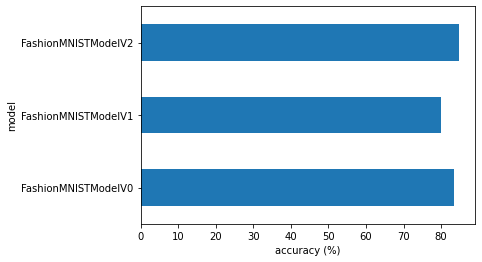

In [65]:
compare_results.set_index("model_name")["model_accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [66]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [67]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [68]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[2.1915e-07, 1.6205e-07, 7.3610e-09, 8.7754e-09, 2.7878e-08, 9.9965e-01,
         1.1756e-06, 1.8451e-05, 5.0129e-07, 3.3402e-04],
        [1.2344e-01, 7.5315e-01, 6.5705e-05, 2.9358e-02, 4.0849e-02, 2.0319e-04,
         5.2403e-02, 2.6042e-04, 2.1444e-04, 5.2449e-05]])

In [69]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[2.1915e-07, 1.6205e-07, 7.3610e-09, 8.7754e-09, 2.7878e-08, 9.9965e-01,
         1.1756e-06, 1.8451e-05, 5.0129e-07, 3.3402e-04],
        [1.2344e-01, 7.5315e-01, 6.5705e-05, 2.9358e-02, 4.0849e-02, 2.0319e-04,
         5.2403e-02, 2.6042e-04, 2.1444e-04, 5.2449e-05]])

In [70]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [71]:
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

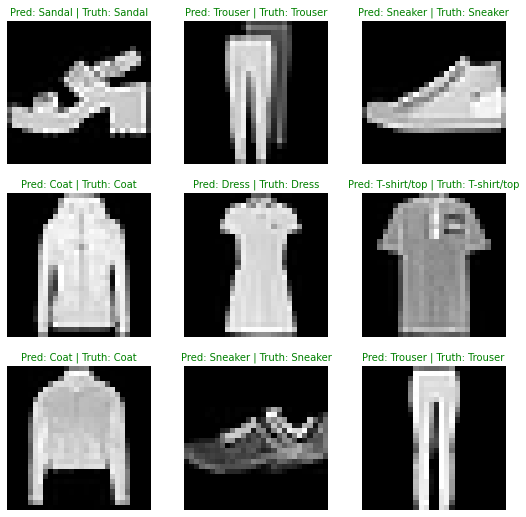

In [72]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [73]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 469.99it/s]


In [74]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [75]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


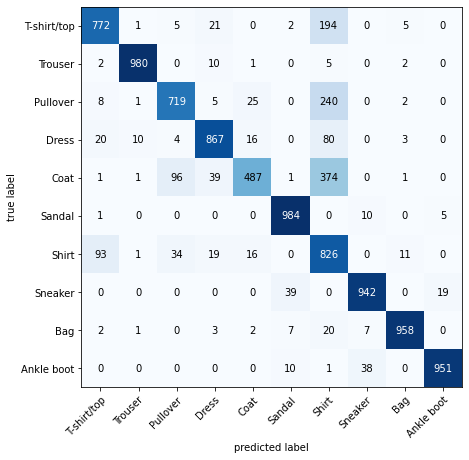

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


In [77]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [78]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [79]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

100%|██████████| 313/313 [00:00<00:00, 465.50it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.39840635657310486,
 'model_accuracy': 84.86421725239616}

In [80]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.39840635657310486,
 'model_accuracy': 84.86421725239616}

In [81]:
torch.isclose(torch.tensor(model_2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)